In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision import utils

In [2]:
seed = 2025
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch.manual_seed(seed)
torch.set_float32_matmul_precision("high")
if device.type == 'cuda':
    torch.cuda.manual_seed_all(seed=seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Using device: cpu


In [3]:
file_path = "../../data/Fashion_MNIST"

train_dataset = datasets.FashionMNIST(root=file_path, train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.FashionMNIST(root=file_path, train=False, download=True, transform=transforms.ToTensor())

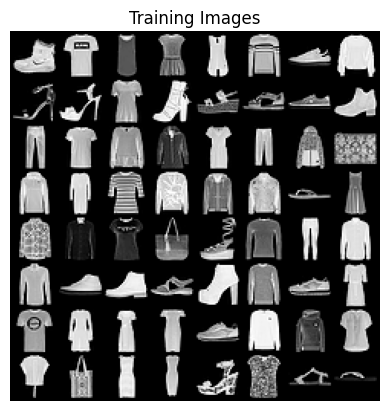

In [4]:
plt.axis('off')
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(torch.cat([train_dataset[i][0].unsqueeze(0) for i in range(64)], dim=0), normalize=True), (1,2,0)))

In [5]:
image_sample, label_sample = train_dataset[0]
print(f"Image shape: {image_sample.shape}, Label: {label_sample}")

Image shape: torch.Size([1, 28, 28]), Label: 9


## Autoencoder Model

In [6]:
class Encoder(nn.Module):
    def __init__(self, latent_dim: int=20):
        super().__init__()

        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc_mean = nn.Linear(128, latent_dim)

    def forward(self, x: torch.Tensor):
        x = x.view(x.size(0), -1) # Flatten the input
        # x = x.flatten() # view 로 사용해도 무방
        x = F.leaky_relu(self.fc1(x), negative_slope=0.2)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.2)
        z = F.leaky_relu(self.fc_mean(x))
        return z
    
class Decoder(nn.Module):
    def __init__(self, latent_dim: int=20):
        super().__init__()

        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 784)

    def forward(self, z: torch.Tensor):
        z = F.leaky_relu(self.fc1(z), negative_slope=0.2)
        z = F.leaky_relu(self.fc2(z), negative_slope=0.2)
        x_hat = F.sigmoid(self.fc3(z))
        x_hat = x_hat.view(x_hat.size(0), 1, 28, 28)
        return x_hat

In [7]:
class Autoencoder(nn.Module):
    def __init__(self, encoder=Encoder, decoder=Decoder, latent_dim: int=20):

        # nn.Module의 __init__ 함수 호출
        super().__init__()
        self.encoder = encoder(latent_dim=latent_dim)
        self.decoder = decoder(latent_dim=latent_dim)
        self.latent_dim = latent_dim # 잠재 벡터

    def forward(self, x: torch.Tensor):
        z = self.encode(x)
        x_hat = self.decode(z)
        return z, x_hat

    def encode(self, x: torch.Tensor):
        return self.encoder(x)

    def decode(self, z: torch.Tensor):
        return self.decoder(z)

In [8]:
class Variational_Encoder(Encoder):
    def __init__(self, latent_dim: int=20):
        super().__init__(latent_dim=latent_dim)

        self.fc_log_var = nn.Linear(128, latent_dim)

    def forward(self, x):
        x = x.view(x.size(0), -1) # Flatten the input
        # x = x.flatten() # view 로 사용해도 무방
        x = F.leaky_relu(self.fc1(x), negative_slope=0.2)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.2)

        mean = self.fc_mean(x) 
        log_var = self.fc_log_var(x)  # 오토 인코더와의 주요 차이점

        return mean, log_var

- 재매개변수화 구현: 재매개변수화 트릭을 이용하여 변분 오토 인코더의 기울기 계산을 가능하게 함
- forward 메소드에 재매개변수화 과정을 추가하여 샘플링 과정을 진행

In [9]:
class Variational_Autoencoder(Autoencoder):
    def __init__(self, encoder=Variational_Encoder, decoder=Decoder, latent_dim: int=16):
        super().__init__(latent_dim=latent_dim)
        self.encoder = encoder(latent_dim)

    def reparameterize(self, mean: torch.Tensor, log_var: torch.Tensor):
        std = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std)
        
        return mean + (epsilon * std)

    def forward(self, x: torch.Tensor):
        mean, log_var = self.encode(x)
        z = self.reparameterize(mean, log_var)
        x_hat = self.decode(z)

        return x_hat, mean, log_var

#### **재매개변수화**

> **VAE**는 오토 인코더 구조를 가지는 **생성 모델**이며, 잠재 변수로부터 디코딩 과정을 거쳐 데이터를 **생성**함  
> 즉, **VAE** 는 오토 인코더에서 데이터를 **복원**하는 것과는 다른 목적을 가지고 있음 이 과정을 VAE 에서는 **샘플링**을 통해 진행  
> 오토 인코더에서 하나의 값으로 정해졌던 인코더의 출력이, 평균과 분산 두 가지로 나뉘며 값이 아닌 분포를 출력하게 됨  
> 평균과 분산을 이용하여 정규 분포를 추정한 후, 해당 분포에서 샘플링을 진행

In [10]:
def KLDivergenceLoss(mean, log_var):
    return torch.sum(-0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp()))

#### **Gaussian Decoder 와 베르누이(Bernoulli) Decoder**

> **VAE** 의 **Decoder** 는 오토 인코더의 **Decoder** 와 같으며, 데이터를 **생성**하는 역할을 담당  
> 이미지 데이터를 생성한다고 가정했을 때, 디코더의 출력 값 범위에 대해 한번 생각해볼 필요가 있음  
> 디코더의 출력은, 인코더의 입력 데이터의 분포를 근사하는 것을 목적으로 하기에 인코더의 입력 값의 분포와 동일한 것이 좋음  
> 디코더의 출력 분포를 베르누이 분포로 가정하면, 복원 손실을 **MSE**가 아니라 **Binary Cross Entropy** 손실을 사용하게 됨

In [11]:
def binary_cross_entropy(x, recon):
    return -torch.sum(x * torch.log(recon) + (1 - x) * torch.log(1 - recon)) 

## VAE Model Train

In [15]:
LR = 0.001
BATCH_SIZE = 100
EPOCHS = 10
latent_dim = 20

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [13]:
vae = Variational_Autoencoder(latent_dim=latent_dim).to(device)
recon_loss = binary_cross_entropy
kld_loss = KLDivergenceLoss
beta = 1
optimizer = optim.Adam(params=list(vae.parameters()), lr=LR)

In [16]:
history = dict(
    train_recon=[],
    train_kld=[],
    valid_recon=[],
    valid_kld=[]
)

print(f"Training start with {EPOCHS} epochs.")
for epoch in range(1, 1 + EPOCHS):
    train_epoch_recon = 0
    train_epoch_kld = 0
    train_size = 0

    vae.train()
    for i, batch in enumerate(train_loader):
        image, label = batch
        image = image.to(device)
        train_size += label.size(0)

        latent_mean, latent_log_var = vae.encode(image) # 평균과 분산을 반환
        latent = vae.reparameterize(latent_mean, latent_log_var) # 잠재 변수를 얻음
        reconstruction_image = vae.decode(latent) # 이미지 복원

        # loss functions 계산
        train_recon = recon_loss(image, reconstruction_image)
        train_kld = kld_loss(latent_mean, latent_log_var)
        train_loss = train_recon + beta*train_kld

        train_epoch_recon += train_recon.item()
        train_epoch_kld += train_kld.item()

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

    test_epoch_recon = 0
    test_epoch_kld = 0
    test_size = 0

    vae.eval()
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            image, label = batch
            image = image.to(device)
            test_size += label.size(0)

            latent_mean, latent_log_var = vae.encode(image)
            latent = vae.reparameterize(latent_mean, latent_log_var)
            reconstruction_image = vae.decode(latent)

            test_recon = recon_loss(image, reconstruction_image)
            test_kld = kld_loss(latent_mean, latent_log_var)
            test_loss = test_recon + test_kld

            test_epoch_recon += test_recon.item()
            test_epoch_kld += test_kld.item()

    train_epoch_recon /= train_size
    train_epoch_kld /= train_size
    test_epoch_recon /= test_size
    test_epoch_kld /= test_size

    history["train_recon"].append(train_epoch_recon)
    history["train_kld"].append(train_epoch_kld)
    history["valid_recon"].append(test_epoch_recon)
    history["valid_kld"].append(test_epoch_kld)

    print(
        f"{epoch}th epoch: "
        + f"Train Recon Loss = {train_epoch_recon:.4f}, "
        + f"KLD loss = {train_epoch_kld:.4f}, "
        + f"Test Recon Loss = {test_epoch_recon:.4f}, "
        + f"KLD loss = {test_epoch_kld:.4f}"
    )

Training start with 10 epochs.
1th epoch: Train Recon Loss = 229.0565, KLD loss = 13.0622, Test Recon Loss = 230.5240, KLD loss = 12.9649
2th epoch: Train Recon Loss = 228.5224, KLD loss = 13.1367, Test Recon Loss = 230.4379, KLD loss = 12.8344
3th epoch: Train Recon Loss = 228.1796, KLD loss = 13.1777, Test Recon Loss = 230.0556, KLD loss = 13.2631
4th epoch: Train Recon Loss = 227.8382, KLD loss = 13.2357, Test Recon Loss = 229.6024, KLD loss = 13.0200
5th epoch: Train Recon Loss = 227.5477, KLD loss = 13.2993, Test Recon Loss = 229.0056, KLD loss = 13.7194
6th epoch: Train Recon Loss = 227.2768, KLD loss = 13.2837, Test Recon Loss = 228.7653, KLD loss = 13.3521
7th epoch: Train Recon Loss = 227.0357, KLD loss = 13.3104, Test Recon Loss = 228.8993, KLD loss = 13.2038
8th epoch: Train Recon Loss = 226.8510, KLD loss = 13.3576, Test Recon Loss = 228.4985, KLD loss = 13.4209
9th epoch: Train Recon Loss = 226.6678, KLD loss = 13.3639, Test Recon Loss = 228.5344, KLD loss = 13.2365
10th e

## Visualize

In [17]:
def visualize_loss(epochs, train_loss, valid_loss):
    x_len = np.arange(epochs)
    plt.plot(x_len, train_loss, marker=".", c="blue", label="Train Loss")
    plt.plot(x_len, valid_loss, marker=".", c="red", label="Valid Loss")
    plt.legend(loc='upper right')
    plt.grid()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

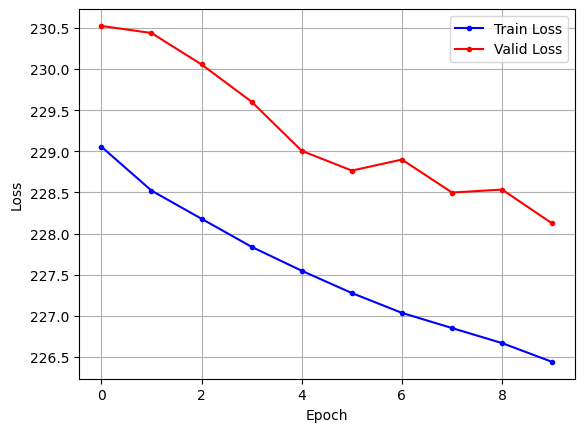

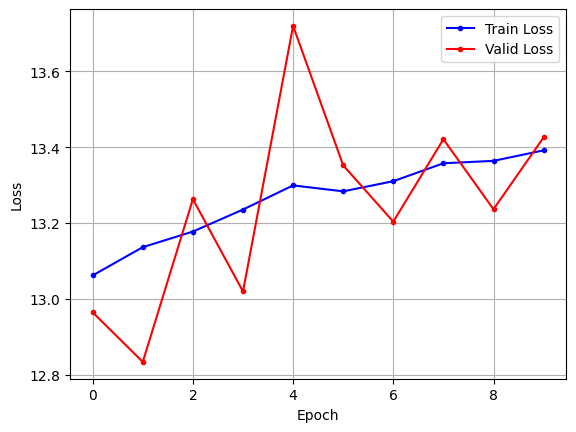

In [20]:
visualize_loss(EPOCHS, history["train_recon"], history["valid_recon"])
visualize_loss(EPOCHS, history["train_kld"], history["valid_kld"])

In [21]:
select = 0

vae.eval()
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        if i != select:
            continue

        test_image, test_label = batch
        test_image = test_image.to(device)
        test_image = test_image.view(BATCH_SIZE, 1 * 28 * 28)

        reconstruction, mean, log_var = vae(test_image)

데이터 배치의 이미지


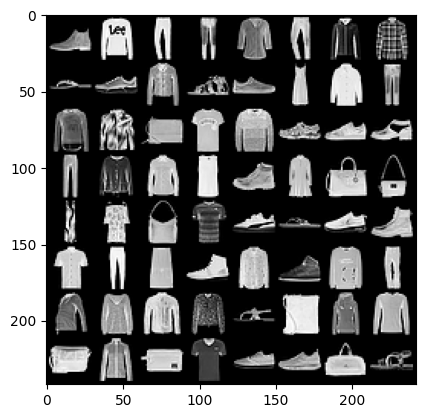

복원된 이미지


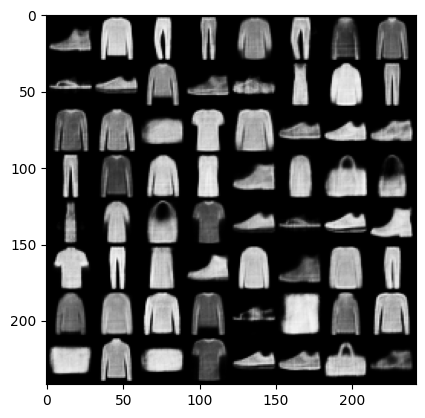

In [22]:
print("데이터 배치의 이미지")
plt.imshow(utils.make_grid(test_image[:64].cpu().view(-1, 1, 28, 28)).permute(1, 2, 0))
plt.show()

print("복원된 이미지")
plt.imshow(utils.make_grid(reconstruction[:64].cpu().view(-1, 1, 28, 28)).permute(1, 2, 0))
plt.show()

In [23]:
with torch.no_grad():
    noise = torch.randn(BATCH_SIZE, latent_dim).to(device)
    generated_images = vae.decode(noise)

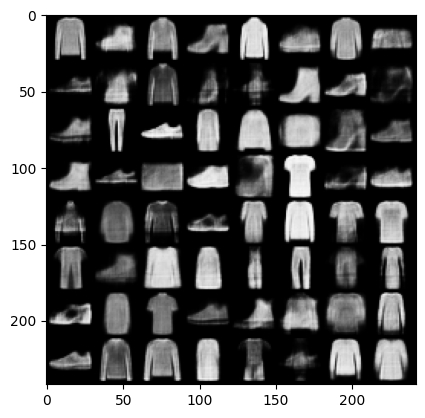

In [24]:
plt.imshow(utils.make_grid(generated_images[:64].cpu().view(-1, 1, 28, 28)).permute(1, 2, 0))
plt.show()